<a href="https://colab.research.google.com/github/ChrisW2420/FedPKDG/blob/main/FedPKDG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPKDG -- Prune + KD + GAN + FL
This prototype implements the algorithm in a distributed setting
TODO:
1. implement a FedAvg aggregator/server
2. build a centralised FL system with n clients connected to the server
3. design experiments to assess accuracy, efficiency, generalisation on homogenoeous data
4. repeat experiments on heterogeneous data, identical model sparsity
5. repeat experiments on heterogeneous data, different model sparsity, mimicing different computational capability of clients

# Setup and Imports

In [1]:
# NB: package versions are very important
!pip install -q tensorflow-model-optimization # for pruning
!pip install -q git+https://github.com/tensorflow/docs # newest tf
!pip install --upgrade keras #newest keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
# 3 versions of keras are used for different functionalities, imported as different names
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import tf_keras as keras_model #only for pruning
from tf_keras import layers as model_layers
import keras
import tempfile
from tf_keras.callbacks import EarlyStopping, Callback
from keras import ops, layers
from tensorflow_docs.vis import embed # for GAN
import matplotlib.pyplot as plt
from tf_keras.preprocessing.image import ImageDataGenerator

In [3]:
# Logging metrics with WandB

# !pip install wandb
# import wandb
# wandb.login()
# from wandb.keras import WandbMetricsLogger

## Loading Data

In [4]:
# MNIST
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Components Implementation

## Model zoo

### CNN

In [5]:
def miniCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="minicnn",
  )
  return model

def smallCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="smallcnn",
  )
  return model

def mediumCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return model

def bigCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="bigcnn",
  )
  return model

### GAN

In [6]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128 # hyperparam, can tune

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

# Create the discriminator.
def Discriminator(latent_dim = 128):
  discriminator = keras.Sequential(
      [
          keras.layers.InputLayer((28, 28, discriminator_in_channels)),
          layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.GlobalMaxPooling2D(),
          layers.Dense(1),
      ],
      name="discriminator",
  )
  return discriminator

# Create the generator.
def Generator():
  generator = keras.Sequential(
      [
          keras.layers.InputLayer((generator_in_channels,)),
          # We want to generate 128 + num_classes coefficients to reshape into a
          # 7x7x(128 + num_classes) map.
          layers.Dense(7 * 7 * generator_in_channels),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Reshape((7, 7, generator_in_channels)),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
      ],
      name="generator",
  )
  return generator

## GAN

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [8]:
# image generation functions
def generate_image(generator, target_class, latent_dim):
    noise_matrix = keras.random.normal(shape=(1, latent_dim))
    # Convert the target label to one-hot encoded vectors.
    target_label = keras.utils.to_categorical([target_class], num_classes)
    target_label = ops.cast(target_label, "float32")
    noise_and_labels = ops.concatenate([noise_matrix, target_label], 1)
    fake = generator.predict(noise_and_labels,verbose = 0)
    return fake


def dataAugmentation(x_initial, y_initial, num_augimg, batch_size):
  datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.1
  )

  # Create empty arrays to store the augmented data
  augmented_images = np.empty((num_augimg, 28, 28, 1), dtype=np.float32)
  augmented_labels = np.empty((num_augimg,), dtype=np.int32)

  # Generate the augmented dataset
  num_batches = num_augimg // batch_size
  counter = 0

  for x_batch, y_batch in datagen.flow(x_initial, y_initial, batch_size=batch_size):
      augmented_images[counter*batch_size:(counter+1)*batch_size] = x_batch
      augmented_labels[counter*batch_size:(counter+1)*batch_size] = y_batch
      counter += 1
      if counter >= num_batches:
          break

  # Verify the shape of the augmented dataset
  print(f"Augmented dataset shape: {augmented_images.shape}, {augmented_labels.shape}")

  # Optionally, combine the augmented data with the original training data
  combined_images = np.concatenate((x_initial, augmented_images), axis=0)
  combined_labels = np.concatenate((y_initial, augmented_labels), axis=0)
  return combined_images, combined_labels


def pseudoDataset(generator, total_num, latent_dim, is_augment=True, batch_size=64): # producing equal numbers of samples for each class
    pseudo_images = []
    if is_augment:
      total_num = total_num//2
    for num in range(10):
      target_class = num
      print('Generating', int(total_num/10), 'fake images of digit', num, '......')
      for _ in range(int(total_num/10)):
        generated_images = generate_image(generator, target_class, latent_dim)
        generated_images *= 255.0
        converted_images = generated_images.astype(np.uint8)
        converted_images = ops.image.resize(converted_images, (28, 28)).numpy().astype(np.uint8)
        pseudo_images.append(converted_images)
    pseudo_images = np.concatenate(pseudo_images, axis=0)
    x_pseudo = pseudo_images.astype("float32") / 255.0
    x_pseudo = np.reshape(x_pseudo, (-1, 28, 28, 1))
    pseudo_labels = np.repeat(np.arange(10), int(total_num/10))

    if is_augment:
      x_pseudo, pseudo_labels = dataAugmentation(x_pseudo, pseudo_labels, total_num, batch_size) #1:1 augmentation to true ratio

    print('Added', pseudo_labels.shape, 'data points to the public dataset')
    return x_pseudo, pseudo_labels

## Pruning

In [9]:
def prune_finetrain(base_model, _epochs, x, y, target_sparsity, fine_tune_epochs, validation_split=0.1):
  callbacks = [
      sparsity.UpdatePruningStep(),
      early_stopping
  ]
  steps_per_epoch = len(x)*(1-validation_split) // batch_size
  begin_step=int(steps_per_epoch*fine_tune_epochs)
  end_step=int(steps_per_epoch*_epochs)+1
  print('begin_step=', begin_step, 'end_step=', end_step)
  pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0, final_sparsity=target_sparsity,
                                              begin_step=begin_step, end_step=end_step) # TODO: tune begin_step, consider fining training before starting to prune

  model_for_pruning = sparsity.prune_low_magnitude(base_model, pruning_schedule=pruning_schedule) #default constant sparsity of 50%

  model_for_pruning.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
  )

  model_for_pruning.fit(
      x,
      y,
      batch_size=batch_size,
      validation_split=validation_split,
      callbacks=callbacks,
      epochs=_epochs,
  )
  pruned_model = sparsity.strip_pruning(model_for_pruning)

  return pruned_model


# Model size metrics

def get_model_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for weight in model.get_weights():
        total_weights += weight.size
        zero_weights += np.count_nonzero(weight == 0)
    return zero_weights / total_weights

def get_gzipped_model_size(model):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, keras_file = tempfile.mkstemp('.h5')
  model.save(keras_file, include_optimizer=False)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)

  return os.path.getsize(zipped_file)

## Knowledge Distillation

In [10]:
class Distiller(keras_model.Model):
    def __init__(self, get_teacher_logits, student, alpha=0.1, temperature=3, **kwargs):
        super(Distiller, self).__init__(**kwargs)
        self.student = student
        self.get_teacher_logits = get_teacher_logits

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha, temperature, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=self.student_loss_fn)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack the data
        x, y = data

        teacher_predictions = self.get_teacher_logits(x)

        with tf.GradientTape() as tape:
            # Forward pass of the student
            student_predictions = self.student(x, training=True)

            # Calculate the task-specific loss
            task_loss = self.student_loss_fn(y, student_predictions)

            # Calculate the soft targets and the distillation loss
            soft_targets = tf.nn.softmax(teacher_predictions / self.temperature)

            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(soft_targets, student_soft)

            # Calculate the total loss
            total_loss = (1 - self.alpha) * task_loss + self.alpha * distillation_loss * (self.temperature ** 2)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"task_loss": task_loss, "distillation_loss": distillation_loss, "total_loss": total_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of the student
        y_pred = self.student(x, training=False)

        # Calculate the task-specific loss
        task_loss = self.student_loss_fn(y, y_pred)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call_model(self):
      return self.student

# Helper Function Implementation

TODO:
Dataset:
- Dataloader
- heterogeneous dataset partition
- data augmentation

visualisation:
- dataset example visualisation
- data distribution visualisation
- confusion matrix
-

In [11]:
def set_model_weights_to_zero(model):
    for layer in model.layers:
        zero_weights = [np.zeros_like(w) for w in layer.get_weights()]
        layer.set_weights(zero_weights)
    return model

In [12]:
def if_synced(model1, model2):
    for layer1, layer2 in zip(model1.layers, model2.layers):
          weights1 = layer1.get_weights()
          weights2 = layer2.get_weights()
          for w1, w2 in zip(weights1, weights2):
              if not np.array_equal(w1, w2):
                  print('different weights, syncing failed')
    print('weights synced for client')

## Callback zoo

In [13]:
early_stopping = EarlyStopping(
    monitor='loss', #default to val_loss
    min_delta=0.001,  # only consider as improvement significant changes
    patience=2,      # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'        # 'min' because we want to minimize the loss
    )

# Client

In [14]:
class Client(): #TODO: add name to clients to refer to them, espeically during logging
  def __init__(self, model_fn, x_train, y_train, **kwargs): #generator = None, discriminator = None, self.latent_dim = 128
    self.cnn = model_fn
    self.generator = Generator()
    self.discriminator = Discriminator()
    self.latent_dim = 128
    self.x_private = x_train
    self.y_private = y_train
    self.batch_size = 64 # hyperparam, can tune
    self.validation_split=0.1

  def train_cnn(self, epochs = 5, is_prune = False, target_sparsity = 0.3, fine_tune_epochs = 0, **kwargs):
    if is_prune:
      print('from gloabl - before pruning client has sparsity', get_model_sparsity(self.cnn))
      self.cnn = prune_finetrain(self.cnn, _epochs = epochs, x = self.x_private, y = self.y_private, target_sparsity = target_sparsity, fine_tune_epochs = fine_tune_epochs) # fine_tune_epochs can take decimals, starts pruning after fine tune
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      print('after pruning client has sparsity', get_model_sparsity(self.cnn))
    else:
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      self.cnn.fit(self.x_private, self.y_private, batch_size=batch_size, epochs=epochs,validation_split=self.validation_split, callbacks=[early_stopping])

  def train_gen(self, epochs = 20, d_learning_rate = 0.0003, g_learning_rate = 0.0003):
    cond_gan = ConditionalGAN(self.discriminator, self.generator, self.latent_dim)
    cond_gan.compile(
        d_optimizer=keras.optimizers.Adam(d_learning_rate),
        g_optimizer=keras.optimizers.Adam(g_learning_rate),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    # produce GAN training dataset
    train_label = keras.utils.to_categorical(self.y_private, 10) # 1 hot encoding label
    dataset = tf.data.Dataset.from_tensor_slices((self.x_private, train_label))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    cond_gan.fit(dataset, epochs=epochs, callbacks=[early_stopping])


  ## the following code act as interface with the server, avoid direct access to private model and dataset

  def produce_logits(self, x): #for KD
    logits = self.cnn(x, training=False)
    print('----getting 1 client logits')
    return logits

  def get_cnn_weights(self): #only for FedAvg, disabled
    return self.cnn.get_weights()

  def get_cnn_classifier(self):
    return self.cnn.layers[-1].get_weights()

  def set_cnn_weights(self, weights): #for downloading global weights
    self.cnn.set_weights(weights)

  def get_gen_weights(self): #only for FedAvg, disabled
    return self.generator.get_weights()

  def set_gen_weights(self, weights): #for downloading global weights
    self.generator.set_weights(weights)

  def get_datasize(self):
    return self.x_private.shape[0]

# Server

In [15]:
class Server():
  def __init__(self, model_fn, client_list, comm_freq = 1, algo = 'FedAvg', **kwargs): #generator = None,
    self.cnn = model_fn
    self.client_list = client_list # calling this param when "uploading" or "downloading"
    self.client_datasize = []
    self.generator = Generator()
    self.latent_dim = 128 # hyperparam, can tune
    self.x_public = np.array([]) # to generate
    self.y_public = np.array([]) # to generate
    self.batch_size = 64 # hyperparam, can tune
    self.comm_freq = comm_freq # no. of client local training epochs before upload

    # default settings for FedAvg
    self.is_prune = False
    self.is_simKD = False

    if algo == 'FedPKDG':
    # turn on FedPKDG
      self.is_prune = True
      self.is_simKD = True

  def get_client_datasize(self):
    if len(self.client_datasize) != len(self.client_list):
      for i in range(len(self.client_datasize), len(self.client_list)):
        self.client_datasize.append(self.client_list[i].get_datasize())
    return self.client_datasize

  def assign_weights_cnn(self, client):
    client.set_cnn_weights(self.cnn.get_weights())

  def assign_weights_gen(self, client):
    client.set_gen_weights(self.generator.get_weights())

  def broadcast(self):
    # TODO: improve: can use tff.federated_map and tff.federated_broadcast, can combine the two assign fns
    for client in self.client_list:
        self.assign_weights_cnn(client)
    for client in self.client_list:
        self.assign_weights_gen(client)

  def local_training(self, cnn_epochs=None, target_sparsity=0.3, fine_tune_epochs = 0, gen_epochs=None):
    for idx, client in enumerate(self.client_list):
      # train the cnn
      print('training client', idx, '\'s CNN')
      if not cnn_epochs:
        cnn_epochs = self.comm_freq
      client.train_cnn(epochs = cnn_epochs, is_prune = self.is_prune, target_sparsity=target_sparsity, fine_tune_epochs = fine_tune_epochs)
      # train the generator
      print('training client', idx, '\'s GEN')
      if not gen_epochs:
        gen_epochs = self.comm_freq
      client.train_gen(epochs = gen_epochs)

  def weighted_average(self, type_of_value ,output):
    print('----getting weighted avg of clients\'', type_of_value)
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
        p_k = p[client_idx]/total_size
        if type_of_value == 'cnn':
          client_val = client.get_cnn_weights()
        elif type_of_value == 'gen':
          client_val = client.get_gen_weights()
        elif type_of_value == 'classifier':
          client_val = client.get_cnn_classifier()
        for val_idx, value in enumerate(client_val):
          output[val_idx] += p_k * value
    return output

  def agg_cnn(self):
    global_weights = [np.zeros_like(w) for w in self.cnn.get_weights()]
    global_weights = self.weighted_average('cnn', global_weights)
    # Set the updated weights to the global model
    self.cnn.set_weights(global_weights)

  def agg_classifier(self):
    # !!TODO: to test, can use tff.federated_mean
    global_weights = [np.zeros_like(w) for w in self.cnn.layers[-1].get_weights()]
    global_weights = self.weighted_average('classifier', global_weights)
    # Set the updated weights to the global model
    self.cnn.layers[-1].set_weights(global_weights)
    self.cnn.layers[-1].trainable = False

  def agg_gen(self):
    global_weights = [np.zeros_like(w) for w in self.generator.get_weights()]
    global_weights = self.weighted_average('gen', global_weights)
    # Set the updated weights to the global model
    self.generator.set_weights(global_weights)

  def produce_pseudo_dataset(self, total_num = None):
    # generate with gen, homogenous data: equal number of datapoints for each class
    #TODO: test pseudoDataset
    if total_num == None:
      total_num = min(self.client_datasize)
    if self.x_public.size==0:
      self.x_public, self.y_public = pseudoDataset(generator=self.generator, total_num=total_num, latent_dim=self.latent_dim)
    else:
      new_x, new_y = pseudoDataset(generator=self.generator, total_num=5*self.batch_size, latent_dim=self.latent_dim)
      self.x_public = np.concatenate((self.x_public, new_x), axis=0)
      self.y_public = np.concatenate((self.y_public, new_y), axis=0)

  def agg_logits(self, data):
    # mimics clients sending their logits to the server given the same input
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
      p_k = p[client_idx]/total_size
      if client_idx == 0:
        logits = p_k * client.produce_logits(data)
      else:
        logits += p_k * client.produce_logits(data)
    print('----getting aggregate client logits',logits)
    return logits

  def distill_to_global(self, epochs=3):
    #!!!TODO: test distillation based on the public_dataset and agg_logits
    if self.is_simKD:
      self.agg_classifier()
    distiller = Distiller(get_teacher_logits = self.agg_logits, student = self.cnn)
    distiller.compile(
      optimizer=keras_model.optimizers.Adam(),
      metrics=[keras_model.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras_model.losses.KLDivergence(),
      alpha=0.4,
      temperature=3,
    )
    # Distill teacher to student
    distiller.fit(self.x_public, self.y_public, epochs=epochs, validation_split=0.1)

    print('should print not trainable:', self.cnn.layers[-1].trainable)
    self.cnn.layers[-1].trainable = True
    print('should print trainable:', self.cnn.layers[-1].trainable)

# Testing Functionality

NB: re-run the server block before every experiment to avoid error: Server class not callable

## FedAvg (Don't Touch)

In [ ]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 1)

for _ in range(3):
  Server.broadcast()
  print('Broadcasted weights to all clients')
  Server.local_training()
  print('trained all clients cnn round', _)
  Server.agg_cnn()
  print('Weighted aggregated client weights')

for client in client_list:
  client.cnn.evaluate(x_test, y_test)

Broadcasted weights to all clients
training client 0 's cnn
282/282 [==============================] - 6s 14ms/step - loss: 0.8666 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.3297 - val_sparse_categorical_accuracy: 0.9050
training client 1 's cnn
282/282 [==============================] - 5s 11ms/step - loss: 0.8512 - sparse_categorical_accuracy: 0.7609 - val_loss: 0.3672 - val_sparse_categorical_accuracy: 0.8970
training client 2 's cnn
282/282 [==============================] - 7s 19ms/step - loss: 0.8463 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.2613 - val_sparse_categorical_accuracy: 0.9210
trained all clients cnn round 0
Weighted aggregated client weights
Broadcasted weights to all clients
training client 0 's cnn
282/282 [==============================] - 6s 14ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2673 - val_sparse_categorical_accuracy: 0.9210
training client 1 's cnn
282/282 [==============================] - 6s 12ms/step - 

In [ ]:
x_train_k = x_train[:no_sample]
y_train_k = y_train[:no_sample]
client = Client(smallCNN(), x_train_k, y_train_k)
client.local_train(epochs=3)
client.cnn.evaluate(x_test, y_test)

Epoch 1/3
282/282 [==============================] - 5s 14ms/step - loss: 0.7805 - sparse_categorical_accuracy: 0.7734 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.9010
Epoch 2/3
282/282 [==============================] - 3s 12ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.2914 - val_sparse_categorical_accuracy: 0.9185
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.2903 - sparse_categorical_accuracy: 0.9135


[0.29031461477279663, 0.9135000109672546]

comment: model quickly overfit to bad training data even after syncing weights, need to prevent this

## Just Pruning (Don't Touch)

In [ ]:
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 1, algo = 'FedPKDG')

for _ in range(3):
  Server.broadcast()
  print('Broadcasted weights to all clients')
  Server.local_training()
  print('trained all clients cnn round', _)
  Server.agg_cnn()
  print('Weighted aggregated client weights')

for client in client_list:
  get_model_sparsity(client.cnn)
  client.cnn.evaluate(x_test, y_test)

after broadcasting client has sparsity 0.0056595559425337396
after broadcasting client has sparsity 0.0056595559425337396
after broadcasting client has sparsity 0.0056595559425337396
Broadcasted weights to all clients
training client 0 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 9s 13ms/step - loss: 0.8240 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.8970
training client 1 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 9s 18ms/step - loss: 0.8242 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.4127 - val_sparse_categorical_accuracy: 0.8890
training client 2 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 7s 12ms/step - loss: 0.8215 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.2855 - val_sparse_categorical_accuracy: 0.9250
trained all clients cnn round 0
before agg client 0 has sparsity 0.4849804092294297
before agg client 1 has spars

In [ ]:
x_train_k = x_train[:no_sample]
y_train_k = y_train[:no_sample]
client = Client(smallCNN(), x_train_k, y_train_k)
client.local_train(epochs = 3, is_prune = True)
client.cnn.evaluate(x_test, y_test)

begin_step= 0 end_step= 844
Epoch 1/3
282/282 [==============================] - 7s 12ms/step - loss: 0.8385 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.8985
Epoch 2/3
282/282 [==============================] - 4s 15ms/step - loss: 0.3786 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.9150
Epoch 3/3
313/313 [==============================] - 2s 3ms/step - loss: 0.3094 - sparse_categorical_accuracy: 0.9068


[0.30936574935913086, 0.9067999720573425]

## Script for FedPKDG

In [ ]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 2, algo='FedPKDG')

total_rounds = 3
for round in range(total_rounds):
  target_sparsity = 0.5*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')
  if round == 0:
    Server.local_training(gen_epochs=10,target_sparsity = target_sparsity)
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset(total_num = 2000)
  else:
    Server.local_training()
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset()
    print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global()
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training()
print('>>>>>>>>>trained all clients cnn final round')
for client in client_list:
  print('local models evaluation')
  client.cnn.evaluate(x_test, y_test)
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)

>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 0 end_step= 563
Epoch 1/2
282/282 [==============================] - 5s 7ms/step - loss: 0.8455 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.3442 - val_sparse_categorical_accuracy: 0.8985
Epoch 2/2
282/282 [==============================] - 2s 5ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.3011 - val_sparse_categorical_accuracy: 0.9135
after pruning client has sparsity 0.0
training client 0 's GEN
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - d_loss: 0.4390 - g_loss: 1.4507
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - d_loss: 0.3727 - g_loss: 1.4628
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.5172 - g_loss: 1.2452
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.5640 - g_loss: 1.1373
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_los

# Experiments

## communication rounds

1. aggregate only after convergence

In [16]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 5, algo='FedPKDG')

total_rounds = 3
for round in range(total_rounds):
  target_sparsity = 0.5*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')
  if round == 0:
    Server.local_training(cnn_epochs = 10, gen_epochs=20, target_sparsity = target_sparsity, fine_tune_epochs=3)
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset(total_num = 2000)
  else:
    Server.local_training(target_sparsity = target_sparsity, fine_tune_epochs=1)
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset()
    print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global()
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training()
print('>>>>>>>>>trained all clients cnn final round')
for client in client_list:
  print('local models evaluation')
  client.cnn.evaluate(x_test, y_test)
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)

>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 843 end_step= 2811
Epoch 1/10
282/282 [==============================] - 36s 11ms/step - loss: 0.7789 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.3392 - val_sparse_categorical_accuracy: 0.9070
Epoch 2/10
282/282 [==============================] - 2s 5ms/step - loss: 0.3341 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.2573 - val_sparse_categorical_accuracy: 0.9240
Epoch 3/10
282/282 [==============================] - 2s 9ms/step - loss: 0.2639 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.2100 - val_sparse_categorical_accuracy: 0.9400
Epoch 4/10
282/282 [==============================] - 1s 5ms/step - loss: 0.2174 - sparse_categorical_accuracy: 0.9357 - val_loss: 0.1741 - val_sparse_categorical_accuracy: 0.9485
Epoch 5/10
282/282 [==============================] - 1s 5ms/step - loss: 0.1893 - sparse_categorical_accur

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - d_loss: 0.4811 - g_loss: 1.4137
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.3996 - g_loss: 1.3748

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.3995 - g_loss: 1.3752
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.4420 - g_loss: 1.3872

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.4421 - g_loss: 1.3870
Epoch 4/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.4617 - g_loss: 1.4091

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.4618 - g_loss: 1.4089
Epoch 5/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.5127 - g_loss: 1.3083

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.5126 - g_loss: 1.3084
Epoch 6/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.5387 - g_loss: 1.2607

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.5385 - g_loss: 1.2612
Epoch 7/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.5055 - g_loss: 1.3490

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.5053 - g_loss: 1.3485
Epoch 8/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.4729 - g_loss: 1.3529

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.4729 - g_loss: 1.3526
Epoch 9/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.3955 - g_loss: 1.5037

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.3956 - g_loss: 1.5040
Epoch 10/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.3204 - g_loss: 1.8348

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.3207 - g_loss: 1.8340
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.2775 - g_loss: 2.0268

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.2775 - g_loss: 2.0267
Epoch 12/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.2387 - g_loss: 2.1339

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.2387 - g_loss: 2.1341
Epoch 13/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.2090 - g_loss: 2.3779

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.2089 - g_loss: 2.3780
Epoch 14/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.1867 - g_loss: 2.4914

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.1867 - g_loss: 2.4912
Epoch 15/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.2025 - g_loss: 2.3824

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.2032 - g_loss: 2.3803
Epoch 16/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.5698 - g_loss: 1.1995

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.5698 - g_loss: 1.1995
Epoch 17/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.5611 - g_loss: 1.3507

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.5610 - g_loss: 1.3510
Epoch 18/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.5942 - g_loss: 1.2076

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.5944 - g_loss: 1.2066
Epoch 19/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.5925 - g_loss: 1.0748

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.5926 - g_loss: 1.0748
Epoch 20/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.5920 - g_loss: 1.1466

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.5922 - g_loss: 1.1458
training client 1 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 843 end_step= 2811
Epoch 1/10
282/282 [==============================] - 6s 7ms/step - loss: 0.7666 - sparse_categorical_accuracy: 0.7703 - val_loss: 0.3679 - val_sparse_categorical_accuracy: 0.8875
Epoch 2/10
282/282 [==============================] - 1s 5ms/step - loss: 0.3289 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.2996 - val_sparse_categorical_accuracy: 0.9035
Epoch 3/10
282/282 [==============================] - 1s 5ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.2437 - val_sparse_categorical_accuracy: 0.9260
Epoch 4/10
282/282 [==============================] - 2s 5ms/step - loss: 0.2099 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.2143 - val_sparse_categorical_accuracy: 0.9350
Epoch 5/10
282/282 [==============================] - 1s 5ms/step - loss: 0.1

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - d_loss: 0.4729 - g_loss: 1.3428
Epoch 2/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.3850 - g_loss: 1.4367

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3852 - g_loss: 1.4370
Epoch 3/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4129 - g_loss: 1.4642

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4128 - g_loss: 1.4647
Epoch 4/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.4144 - g_loss: 1.5888

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.4146 - g_loss: 1.5883
Epoch 5/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4891 - g_loss: 1.3921

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4890 - g_loss: 1.3926
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4830 - g_loss: 1.4516

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4830 - g_loss: 1.4514
Epoch 7/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4379 - g_loss: 1.4299

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4379 - g_loss: 1.4302
Epoch 8/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4284 - g_loss: 1.5224

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4283 - g_loss: 1.5226
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.3929 - g_loss: 1.6799

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.3929 - g_loss: 1.6800
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.3181 - g_loss: 1.9139

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3181 - g_loss: 1.9139
Epoch 11/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.3009 - g_loss: 1.9451

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.3007 - g_loss: 1.9456
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.2559 - g_loss: 2.1470

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.2558 - g_loss: 2.1472
Epoch 13/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.2048 - g_loss: 2.3015

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.2048 - g_loss: 2.3016
Epoch 14/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.1729 - g_loss: 2.4932

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.1729 - g_loss: 2.4933
Epoch 15/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.1488 - g_loss: 2.7003

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.1488 - g_loss: 2.7003
Epoch 16/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.1454 - g_loss: 2.7365

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.1456 - g_loss: 2.7356
Epoch 17/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.5243 - g_loss: 1.5501

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.5248 - g_loss: 1.5485
Epoch 18/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.5824 - g_loss: 1.2091

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.5824 - g_loss: 1.2105
Epoch 19/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4387 - g_loss: 1.9382

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4389 - g_loss: 1.9369
Epoch 20/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6448 - g_loss: 1.0119

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6447 - g_loss: 1.0119
training client 2 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 843 end_step= 2811
Epoch 1/10
282/282 [==============================] - 6s 7ms/step - loss: 0.7764 - sparse_categorical_accuracy: 0.7644 - val_loss: 0.2478 - val_sparse_categorical_accuracy: 0.9360
Epoch 2/10
282/282 [==============================] - 1s 5ms/step - loss: 0.3272 - sparse_categorical_accuracy: 0.9022 - val_loss: 0.1933 - val_sparse_categorical_accuracy: 0.9520
Epoch 3/10
282/282 [==============================] - 1s 5ms/step - loss: 0.2526 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.1628 - val_sparse_categorical_accuracy: 0.9585
Epoch 4/10
282/282 [==============================] - 1s 5ms/step - loss: 0.2097 - sparse_categorical_accuracy: 0.9373 - val_loss: 0.1362 - val_sparse_categorical_accuracy: 0.9655
Epoch 5/10
282/282 [==============================] - 2s 5ms/step - loss: 0.

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - d_loss: 0.5101 - g_loss: 1.2374
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.3552 - g_loss: 1.6235

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3552 - g_loss: 1.6239
Epoch 3/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.3924 - g_loss: 1.5021

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.3925 - g_loss: 1.5017
Epoch 4/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4455 - g_loss: 1.4985

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4454 - g_loss: 1.4985
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4779 - g_loss: 1.4446

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4778 - g_loss: 1.4447
Epoch 6/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4922 - g_loss: 1.3052

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4921 - g_loss: 1.3056
Epoch 7/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.4310 - g_loss: 1.4833

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4310 - g_loss: 1.4834
Epoch 8/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.3885 - g_loss: 1.5541

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.3884 - g_loss: 1.5544
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.3699 - g_loss: 1.6929

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3698 - g_loss: 1.6932
Epoch 10/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.3100 - g_loss: 1.9655

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.3100 - g_loss: 1.9648
Epoch 11/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.2799 - g_loss: 1.9331

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.2800 - g_loss: 1.9332
Epoch 12/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.5286 - g_loss: 1.4303

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.5292 - g_loss: 1.4287
Epoch 13/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6377 - g_loss: 0.9263

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6376 - g_loss: 0.9265
Epoch 14/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6291 - g_loss: 0.9640

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.6291 - g_loss: 0.9640
Epoch 15/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6287 - g_loss: 0.9350

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.6287 - g_loss: 0.9350
Epoch 16/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6304 - g_loss: 0.9277

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6304 - g_loss: 0.9279
Epoch 17/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6452 - g_loss: 0.8986

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6451 - g_loss: 0.8986
Epoch 18/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6390 - g_loss: 0.9124

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.6391 - g_loss: 0.9123
Epoch 19/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6435 - g_loss: 0.8747

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.6435 - g_loss: 0.8746
Epoch 20/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6514 - g_loss: 0.8517

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6514 - g_loss: 0.8517
>>>>>>>>>trained all clients cnn round 
----getting weighted avg of clients' gen
>>>>>>>>>Weighted aggregated client generator
Generating 100 fake images of digit 0 ......
Generating 100 fake images of digit 1 ......
Generating 100 fake images of digit 2 ......
Generating 100 fake images of digit 3 ......
Generating 100 fake images of digit 4 ......
Generating 100 fake images of digit 5 ......
Generating 100 fake images of digit 6 ......
Generating 100 fake images of digit 7 ......
Generating 100 fake images of digit 8 ......
Generating 100 fake images of digit 9 ......
Augmented dataset shape: (1000, 28, 28, 1), (1000,)
Added (2000,) data points to the public dataset
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting 1 cli

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - d_loss: 0.3990 - g_loss: 1.5573
Epoch 2/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.5893 - g_loss: 1.2672

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - d_loss: 0.5894 - g_loss: 1.2668
Epoch 3/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6031 - g_loss: 1.0798

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - d_loss: 0.6032 - g_loss: 1.0798
Epoch 4/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.6281 - g_loss: 1.0282

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.6282 - g_loss: 1.0277
Epoch 5/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.6483 - g_loss: 1.0499

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.6483 - g_loss: 1.0498
training client 1 's CNN
from gloabl - before pruning client has sparsity 0.0
begin_step= 281 end_step= 1406
Epoch 1/5
282/282 [==============================] - 6s 9ms/step - loss: 0.2961 - sparse_categorical_accuracy: 0.9124 - val_loss: 0.2272 - val_sparse_categorical_accuracy: 0.9290
Epoch 2/5
282/282 [==============================] - 2s 5ms/step - loss: 0.1877 - sparse_categorical_accuracy: 0.9457 - val_loss: 0.1871 - val_sparse_categorical_accuracy: 0.9425
Epoch 3/5
282/282 [==============================] - 2s 5ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9534 - val_loss: 0.1674 - val_sparse_categorical_accuracy: 0.9490
Epoch 4/5
282/282 [==============================] - 2s 6ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9574 - val_loss: 0.1516 - val_sparse_categorical_accuracy: 0.9535
Epoch 5/5
282/282 [==============================] - 2s 5ms/step - loss: 0.1294 - sparse_categorica

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - d_loss: 0.3857 - g_loss: 1.8278
Epoch 2/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.5954 - g_loss: 1.1981

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - d_loss: 0.5957 - g_loss: 1.1977
Epoch 3/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.6488 - g_loss: 1.0304

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.6489 - g_loss: 1.0306
Epoch 4/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.6898 - g_loss: 0.9465

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.6897 - g_loss: 0.9465
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.6757 - g_loss: 0.9165

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.6757 - g_loss: 0.9165
training client 2 's CNN
from gloabl - before pruning client has sparsity 0.0
begin_step= 281 end_step= 1406
Epoch 1/5
282/282 [==============================] - 5s 7ms/step - loss: 0.2865 - sparse_categorical_accuracy: 0.9149 - val_loss: 0.1436 - val_sparse_categorical_accuracy: 0.9620
Epoch 2/5
282/282 [==============================] - 2s 6ms/step - loss: 0.1885 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.1202 - val_sparse_categorical_accuracy: 0.9705
Epoch 3/5
282/282 [==============================] - 2s 6ms/step - loss: 0.1582 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.1089 - val_sparse_categorical_accuracy: 0.9710
Epoch 4/5
282/282 [==============================] - 2s 6ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9571 - val_loss: 0.0923 - val_sparse_categorical_accuracy: 0.9790
Epoch 5/5
282/282 [==============================] - 3s 9ms/step - loss: 0.1307 - sparse_categoric

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.4093 - g_loss: 1.3608
Epoch 2/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.4606 - g_loss: 1.4149

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.4607 - g_loss: 1.4146
Epoch 3/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.5835 - g_loss: 1.0783

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.5835 - g_loss: 1.0781
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.5940 - g_loss: 1.0367

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.5941 - g_loss: 1.0366
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6387 - g_loss: 0.9268

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6387 - g_loss: 0.9268
>>>>>>>>>trained all clients cnn round 
----getting weighted avg of clients' gen
>>>>>>>>>Weighted aggregated client generator
Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape: (160, 28, 28, 1), (160,)
Added (320,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - d_loss: 0.6677 - g_loss: 0.9456
Epoch 2/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.6673 - g_loss: 0.9439

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.6673 - g_loss: 0.9437
Epoch 3/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - d_loss: 0.6600 - g_loss: 0.9040

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - d_loss: 0.6601 - g_loss: 0.9039
Epoch 4/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6790 - g_loss: 0.8211

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6790 - g_loss: 0.8212
Epoch 5/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6791 - g_loss: 0.8734

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6792 - g_loss: 0.8731
training client 1 's CNN
from gloabl - before pruning client has sparsity 0.0805398345668263
begin_step= 281 end_step= 1406
Epoch 1/5
282/282 [==============================] - 6s 7ms/step - loss: nan - sparse_categorical_accuracy: 0.0958 - val_loss: nan - val_sparse_categorical_accuracy: 0.1030
Epoch 2/5
282/282 [==============================] - 2s 6ms/step - loss: nan - sparse_categorical_accuracy: 0.0958 - val_loss: nan - val_sparse_categorical_accuracy: 0.1030
Epoch 2: early stopping
after pruning client has sparsity 0.0
training client 1 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 0.7191 - g_loss: 0.8242

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - d_loss: 0.7191 - g_loss: 0.8242
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6885 - g_loss: 0.8694

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - d_loss: 0.6885 - g_loss: 0.8693
Epoch 3/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6968 - g_loss: 0.8453

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.6969 - g_loss: 0.8450
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.7015 - g_loss: 0.7686

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.7015 - g_loss: 0.7686
Epoch 5/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6942 - g_loss: 0.7963

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6942 - g_loss: 0.7961
training client 2 's CNN
from gloabl - before pruning client has sparsity 0.0805398345668263
begin_step= 281 end_step= 1406
Epoch 1/5
282/282 [==============================] - 6s 9ms/step - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0970
Epoch 2/5
282/282 [==============================] - 2s 6ms/step - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0970
Epoch 2: early stopping
after pruning client has sparsity 0.0
training client 2 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 0.6348 - g_loss: 0.9040

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - d_loss: 0.6348 - g_loss: 0.9042
Epoch 2/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6099 - g_loss: 1.0050

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6100 - g_loss: 1.0046
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6529 - g_loss: 0.8790

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.6529 - g_loss: 0.8789
Epoch 4/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6728 - g_loss: 0.8340

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6728 - g_loss: 0.8340
Epoch 5/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - d_loss: 0.6664 - g_loss: 0.8232

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.6664 - g_loss: 0.8232
>>>>>>>>>trained all clients cnn round 
----getting weighted avg of clients' gen
>>>>>>>>>Weighted aggregated client generator
Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape: (160, 28, 28, 1), (160,)
Added (320,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
-

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - d_loss: 0.7016 - g_loss: 0.8098
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6923 - g_loss: 0.7803

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6923 - g_loss: 0.7804
Epoch 3/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6777 - g_loss: 0.8132

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6778 - g_loss: 0.8131
Epoch 4/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - d_loss: 0.6946 - g_loss: 0.7625

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - d_loss: 0.6946 - g_loss: 0.7626
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6909 - g_loss: 0.7654

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.6908 - g_loss: 0.7654
training client 1 's CNN
from gloabl - before pruning client has sparsity 0.0
begin_step= 0 end_step= 1406
Epoch 1/5
282/282 [==============================] - 5s 7ms/step - loss: nan - sparse_categorical_accuracy: 0.0958 - val_loss: nan - val_sparse_categorical_accuracy: 0.1030
Epoch 2/5
282/282 [==============================] - 2s 6ms/step - loss: nan - sparse_categorical_accuracy: 0.0958 - val_loss: nan - val_sparse_categorical_accuracy: 0.1030
Epoch 2: early stopping
after pruning client has sparsity 0.0
training client 1 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.6997 - g_loss: 0.7709

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - d_loss: 0.6997 - g_loss: 0.7709
Epoch 2/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6965 - g_loss: 0.7841

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.6965 - g_loss: 0.7841
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.7035 - g_loss: 0.7575

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.7035 - g_loss: 0.7575
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6900 - g_loss: 0.7497

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6900 - g_loss: 0.7497
Epoch 5/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6946 - g_loss: 0.7574

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.6947 - g_loss: 0.7572
training client 2 's CNN
from gloabl - before pruning client has sparsity 0.0
begin_step= 0 end_step= 1406
Epoch 1/5
282/282 [==============================] - 6s 8ms/step - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0970
Epoch 2/5
282/282 [==============================] - 2s 9ms/step - loss: nan - sparse_categorical_accuracy: 0.1003 - val_loss: nan - val_sparse_categorical_accuracy: 0.0970
Epoch 2: early stopping
after pruning client has sparsity 0.0
training client 2 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 0.6735 - g_loss: 0.8152

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - d_loss: 0.6735 - g_loss: 0.8153
Epoch 2/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - d_loss: 0.6571 - g_loss: 0.8892

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6572 - g_loss: 0.8887
Epoch 3/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6740 - g_loss: 0.8108

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6739 - g_loss: 0.8109
Epoch 4/5
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6651 - g_loss: 0.8238

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.6650 - g_loss: 0.8240
Epoch 5/5
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 0.6799 - g_loss: 0.7900

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.6799 - g_loss: 0.7900
>>>>>>>>>trained all clients cnn final round
local models evaluation
313/313 [==============================] - 1s 2ms/step - loss: nan - sparse_categorical_accuracy: 0.0980
local models evaluation
313/313 [==============================] - 1s 2ms/step - loss: nan - sparse_categorical_accuracy: 0.0980
local models evaluation
313/313 [==============================] - 1s 3ms/step - loss: nan - sparse_categorical_accuracy: 0.0980
global model evaluation
313/313 [==============================] - 2s 3ms/step - loss: nan - sparse_categorical_accuracy: 0.0984


[nan, 0.09840217977762222]

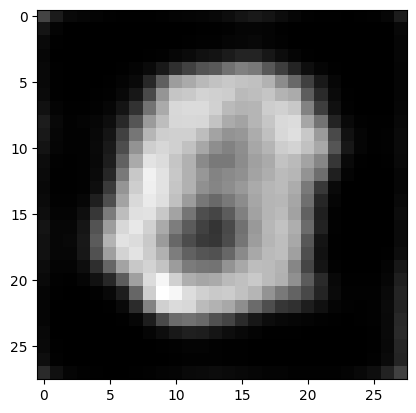

0


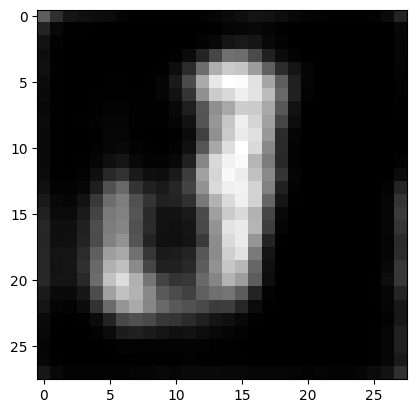

1


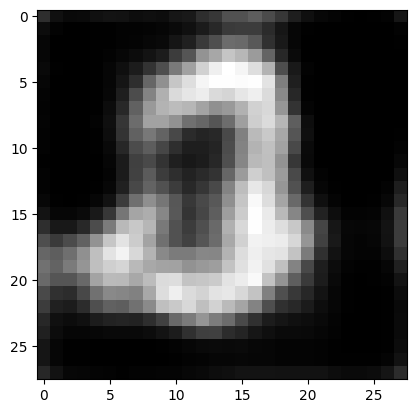

2


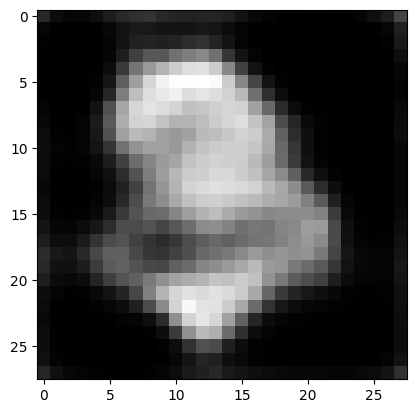

3


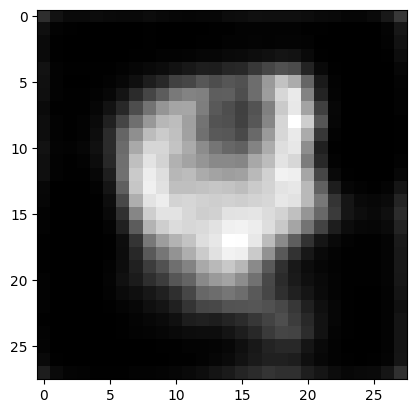

4


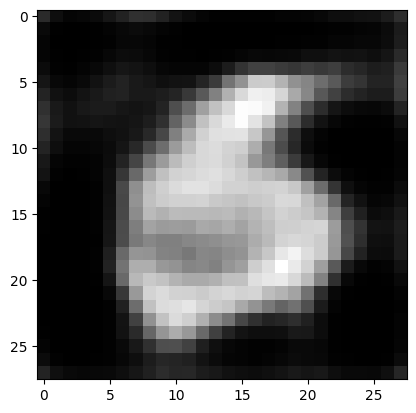

5


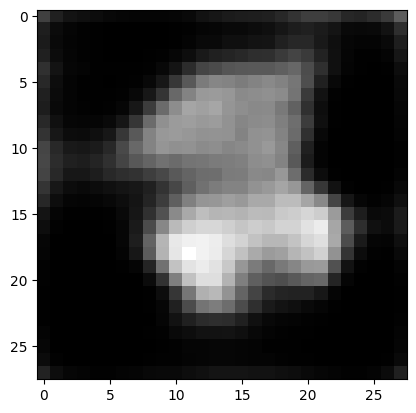

6


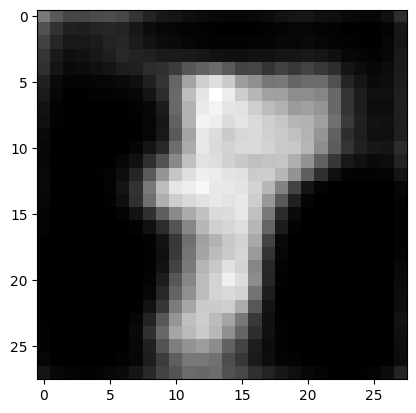

7


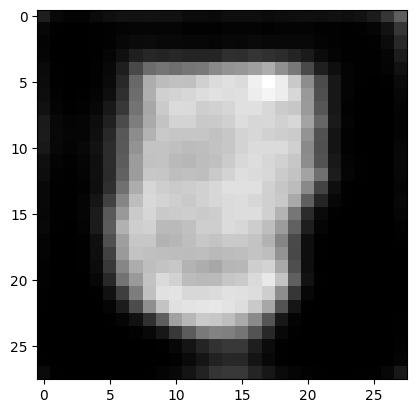

8


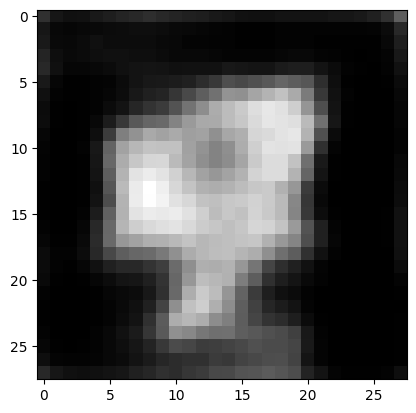

9


In [17]:
for idx in range(10):
  pos = idx*100+20
  img = Server.x_public[pos]
  label = Server.y_public[pos]
  plt.imshow(img, cmap='gray')
  plt.show()
  print(label)

In [37]:
img = generate_image(client_list[1].generator, 5, latent_dim)

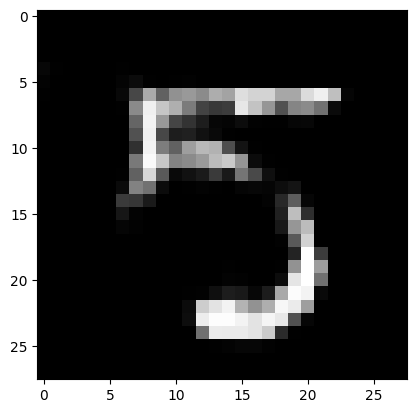

In [38]:
plt.imshow(img[0], cmap='gray')
plt.show()

# TODO list:
- add wandb to the training steps to record metrics
- tune the parameters to achieve better performances

numbers to consider:

number of rounds of training

compare:
using logits or feature map output ie layer[-2]


- set up homogeneous experiments
- set up heterogenous experiments